Dataset Link: https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction

In [12]:
### Please execute the code in order!!!

In [13]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.stats import norm
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import keras as keras
from tensorflow.keras import layers
from keras import regularizers
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import ModelCheckpoint


#### Load Data

In [14]:
# Load Data
df = pd.read_csv('energydata_complete.csv')
#df.head()

# Initial cleaning
df['Appliances'] = df['Appliances'] + df['lights']
df = df.rename(columns={'Appliances': 'Usage'})

# Dropping useless featues
df = df.drop(['lights', 'date', 'rv1', 'rv2'], axis = 1)

# Seperating into X and y
X_pd = df.drop('Usage', axis = 1)
y_pd = df['Usage']
#print(X['T1'].nunique())
#print(y.head(3))
#print(y.describe())

# Saving as numpy arrays
y = y_pd.to_numpy()
X = X_pd.to_numpy()

# Creating classes. Outliers > 320 = class 1 others =  class 0
# Calculate Z-score
arr = y
z_scores = (arr - np.mean(arr)) / np.std(arr)

# Define a threshold for outlier detection
threshold = 2

# Create a new array with outliers labeled as 1 and the rest as 0
outliers_mask = np.abs(z_scores) > threshold
y_class = np.where(outliers_mask, 1, 0)

""" 
X is the feature 2d array
y is the numerical 1d array for regression
y_class is the binary 1d array for classification
"""


## OVERSAMPLING AS Class 1 is limited

# Separate examples by class
X_class0 = X[y_class == 0]
X_class1 = X[y_class == 1]

# Oversample class 1
X_class1_oversampled = resample(X_class1, replace=True, n_samples=X_class0.shape[0], random_state=42)

# Concatenate oversampled class 1 with original class 0
X_oversampled = np.concatenate((X_class0, X_class1_oversampled), axis=0)
y_oversampled = np.concatenate((np.zeros(X_class0.shape[0], dtype=int), np.ones(X_class0.shape[0], dtype=int)), axis=0)

In [15]:
## Creating test and train split
X_oversampled, X_oversampled_test, y_oversampled, y_oversampled_test = train_test_split(X_oversampled, y_oversampled, test_size = 0.1, random_state=0, shuffle=True)

#### EDA

In [16]:
X_pd.head()

,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,...,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
0,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,...,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3
1,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,...,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2
2,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,...,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1
3,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,...,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0
4,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,...,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9


In [17]:
# Checking for duplicates
print(X_pd.duplicated())


0        False
1        False
2        False
3        False
4        False
         ...  
19730    False
19731    False
19732    False
19733    False
19734    False
Length: 19735, dtype: bool


In [18]:
# General Statistics for the dataset
X_pd.describe()

,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,...,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,...,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,19.592106,50.949283,...,22.029107,42.936165,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707
std,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,1.844623,9.022034,...,1.956162,5.224361,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648
min,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,15.330000,29.815000,...,16.306667,29.600000,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000
25%,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,18.277500,45.400000,...,20.790000,39.066667,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000
50%,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,19.390000,49.090000,...,22.100000,42.375000,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333
75%,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,20.619643,53.663333,...,23.390000,46.536000,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667
max,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,25.795000,96.321667,...,27.230000,58.780000,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000


In [19]:
# Checking for missing values
X_pd.isna().sum()

T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
dtype: int64

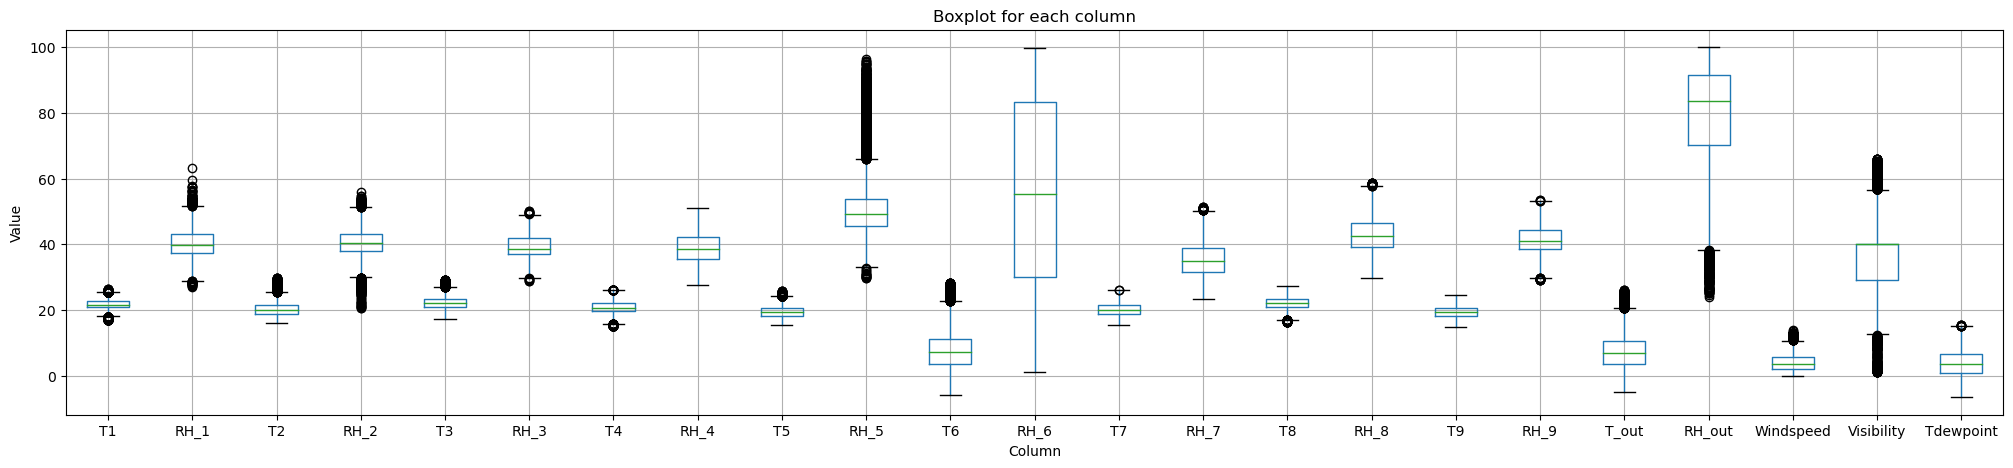

In [20]:
# Checking for outliers
# create a larger plot
X_new = X_pd.drop('Press_mm_hg', axis = 1)
fig, ax = plt.subplots(figsize=(25, 5))

# create a boxplot for each column
X_new.boxplot(ax=ax)

# set the title and axis labels
plt.title('Boxplot for each column')
plt.xlabel('Column')
plt.ylabel('Value')

# show the plot
plt.show()

<Axes: xlabel='Usage', ylabel='Count'>

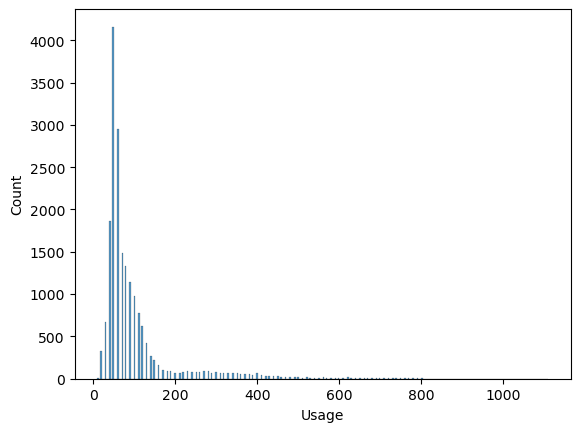

In [21]:
# Check the distribution of the target variable
sns.histplot(y_pd)

<Axes: >

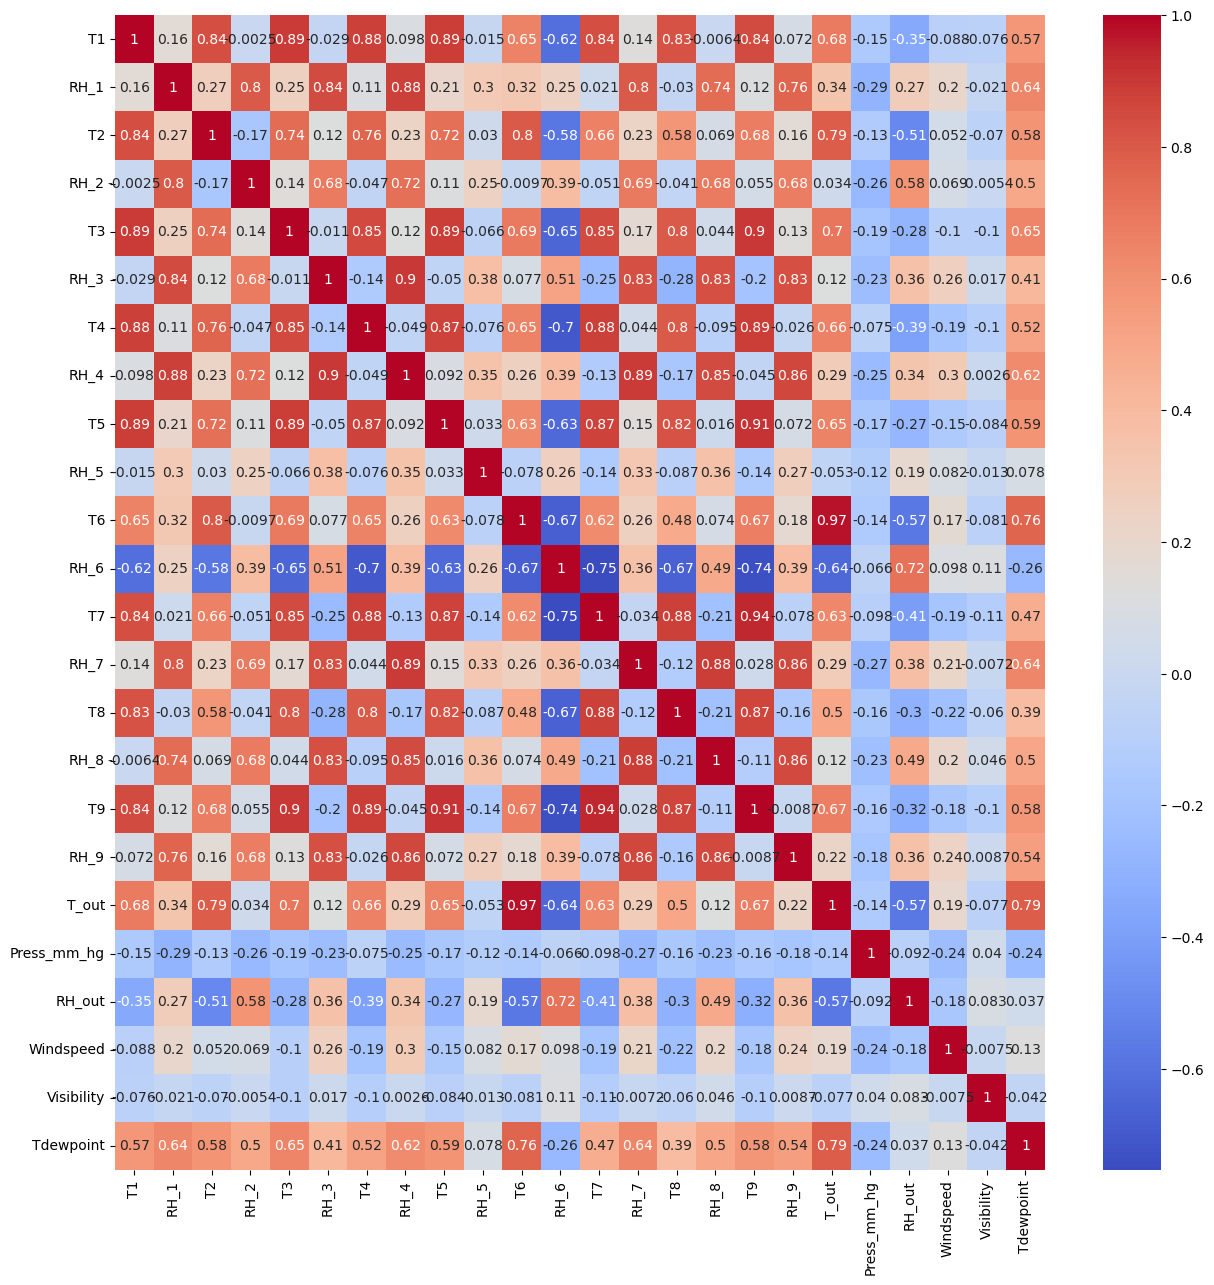

In [22]:
# Correlation Analysis
from sklearn.preprocessing import MinMaxScaler

# Initialize scaler
scaler = MinMaxScaler()

# Normalize data
normalized_X = scaler.fit_transform(X_pd)

# Convert to DataFrame
df_normalized = pd.DataFrame(normalized_X, columns=X_pd.columns)

# Calculate correlation matrix
corr_matrix = df_normalized.corr()

# Setting the size of the plot
fig, ax = plt.subplots(figsize=(15, 15))

# Plot heatmap
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", ax=ax)

#### PCA

In [23]:
"""
Input: Data matrix X, where each row represents a sample and each column represents a feature.
Standardize the data matrix X by subtracting the mean of each column and dividing by the standard deviation of each column.
Calculate the covariance matrix C of the standardized data matrix X.
Calculate the eigenvectors and eigenvalues of the covariance matrix C.
Sort the eigenvalues in decreasing order and choose the k eigenvectors that correspond to the k largest eigenvalues.
Construct the projection matrix P by concatenating the k eigenvectors as columns.
Project the standardized data matrix X onto the projection matrix P to obtain the reduced dimensionality dataset Y = X P.
Output: The reduced dimensionality dataset Y, where each row represents a sample and each column represents a principal component.
"""

'\nInput: Data matrix X, where each row represents a sample and each column represents a feature.\nStandardize the data matrix X by subtracting the mean of each column and dividing by the standard deviation of each column.\nCalculate the covariance matrix C of the standardized data matrix X.\nCalculate the eigenvectors and eigenvalues of the covariance matrix C.\nSort the eigenvalues in decreasing order and choose the k eigenvectors that correspond to the k largest eigenvalues.\nConstruct the projection matrix P by concatenating the k eigenvectors as columns.\nProject the standardized data matrix X onto the projection matrix P to obtain the reduced dimensionality dataset Y = X P.\nOutput: The reduced dimensionality dataset Y, where each row represents a sample and each column represents a principal component.\n'

In [24]:
def cumsum(arr):
    result = []
    total = 0
    for i in arr:
        total += i
        result.append(total)
    return result

def PCA(X, required_variance_percent = 95):
    """
    Returns the transformed X matrix (2d numpy array)
    """
    X_original = X
    # Normalizing the data first
    X_mean = np.mean(X, axis = 0)
    X = X - X_mean
    #print(X.shape)

    #Calculating the covariance matrix
    cov_matrix = np.cov(X.T)
    #print(cov_matrix.shape)
    
    # calculate the eigenvectors and eigenvalues of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    # Sorting according to eigenvalues
    idx = np.argsort(eigenvalues) # returns the indices of the sorted eigenvalues
    idx = idx[::-1]
    eigenvectors = eigenvectors.T[idx]
    eigenvalues = eigenvalues[idx]
    #print(eigenvectors.shape)

    # Explained Variance
    total_variance = sum(eigenvalues)
    explained_variance = eigenvalues/total_variance * 100
    explained_variance = cumsum(explained_variance)

    # Deciding how many components to select
    num_components = 1
    for i in explained_variance:
        if i > required_variance_percent:
            break
        else:
            num_components = num_components + 1 

    # Selecting the number of components
    pc = eigenvectors[:num_components,:]
    #print(pc.shape)

    # Transforming the matrix 
    transformed_matrix = np.dot(X, pc.T)
    print(transformed_matrix.shape[1])

    return transformed_matrix, eigenvalues, eigenvectors, explained_variance, cov_matrix

# Note that the transformed matrix is not normalized
# Test
# transformed_matrix, eigenvalues, eigenvectors, explained_variance, cov_matrix = PCA(X,required_variance_percent= 95)



In [25]:
transformed_matrix, eigenvalues, eigenvectors, explained_variance, cov_matrix = PCA(X,required_variance_percent= 95)
explained_variance

6


[68.19355598301854,
 77.1366100953018,
 84.9542610173974,
 90.81630069423295,
 94.61825205140693,
 97.41288075969864,
 98.07668203022577,
 98.52698594424359,
 98.96817791106416,
 99.19852653889913,
 99.39575218447344,
 99.54919055210222,
 99.69623548337728,
 99.77228119335888,
 99.82505530063776,
 99.86635250137249,
 99.9025096757249,
 99.92992919464952,
 99.95307469924991,
 99.96988646281521,
 99.9823486178619,
 99.99015240707638,
 99.99579067544447,
 100.00000000000004]

### Regression

#### Linear Regression

In [26]:
class LinearRegression:

    def __init__(self, X, y, learningrate, maxIteration, epsilon, regpara = 100, regularization = False, PCA = False, print = True):
        self.learningrate = learningrate
        self.X = X
        self.y = y
        self.epsilon = epsilon
        self.maxIteration = maxIteration
        self.regularization = regularization
        self.regpara = regpara
        self.PCA = PCA
        self.print = print

    def splitData(self):
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size = 0.3, random_state=0, shuffle=True)
        return X_train, X_test, y_train, y_test

    def add_X0(self, X):
        return np.column_stack([np.ones(X.shape[0]), X])

    def normalizeTrain(self, X):
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0)
        X_norm = (X - mean)/std
        # First normalize then add column of 0 otherwise you get division by 0 error
        X_norm = self.add_X0(X_norm)
        return X_norm, mean, std

    def normalizeTest(self, X, mean, std):
        X_norm = (X - mean)/ std
        X_norm = self.add_X0(X_norm)
        return X_norm
    
    def predict(self, X, weights = None):
        if weights == None:
            weights = self.w
        return X.dot(weights)

    def sse(self, X, y):
        y_hat = self.predict(X)
        if self.regularization == False:
            z = ((y_hat-y) ** 2).sum()
            #print(z)
            return z
        elif self.regularization == True:
            z = ((y_hat-y)**2).sum() - (self.regpara*(self.w)**2).sum()
            return z

    def costFunction(self, X, y):
        # RMSE or SSE
          return self.sse(X, y)

    def costDerivative(self, X, y):
        y_hat = self.predict(X)
        if self.regularization == False:
            return X.T.dot((y_hat - y))
        elif self.regularization == True:
            #print(X.T.dot((y_hat - y)) + self.regpara*(self.w))
            return X.T.dot((y_hat - y)) + self.regpara*(self.w)
        

    def stochasticgradientDescent(self, X, y):
        errors = []
        error_prev = 2000000
        
        for i in tqdm(range(self.maxIteration)):
          selected_indices = np.random.choice(X.shape[0], size=50, replace=True)
          sample_X = X[selected_indices]
          sample_y = y[selected_indices]
           
          gradient = self.costDerivative(sample_X, sample_y)
          self.w = self.w-self.learningrate * gradient
          current_error = self.costFunction(sample_X, sample_y)
          errors.append(current_error)
          if np.abs(current_error - error_prev) < self.epsilon:
            print("Model Stopped Learning")
            break
          error_prev = current_error

    def calculate_rmse(self, X_test, y_test, theta):
          mse = np.mean((X_test.dot(theta)-y_test)**2)
          rmse = np.sqrt(mse)
          return rmse

    def sum_squared_errors(self, X_test, y_test, theta):
          sse = sum((y[i] - X_test.dot(theta)[i])**2 for i in range(len(y_test)))
          return sse
    
    def calculate_r2(self, X_test, y_pred):
        y_true = self.predict(X_test)
        r2 = r2_score(y_true, y_pred)
        return r2

    def fit(self):
          if self.PCA == True:
              print("Using PCA with 95% variance and Number of PC:")
              self.X, self.eigenvalues, self.eigenvectors, self.explained_variance, self.cov_matrix = PCA(self.X)
            
          X_train, X_test, y_train, y_test = self.splitData()
          X_train, mean, std = self.normalizeTrain(X_train)
          X_test = self.normalizeTest(X_test, mean, std)

          self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test
          
          self.w = np.zeros(X_train.shape[1])
          
          
          self.stochasticgradientDescent(X_train, y_train)

          if self.print == True:
            print("Solving using Stochastic Gradient Descent")
            print("Weights")
            print(self.w)
            print("RMSE")
            print(self.calculate_rmse(X_test, y_test, self.w))
            print("SSE")
            print(self.sum_squared_errors(X_test, y_test, self.w))
          return 

    

In [27]:
lr_model = LinearRegression(X, y, learningrate=0.004, maxIteration=5000, epsilon= 0.005, regpara=30, regularization=False, PCA = True, print = True)
lr_model.fit()

Using PCA with 95% variance and Number of PC:
6


100%|██████████| 5000/5000 [00:00<00:00, 18387.83it/s]


Solving using Stochastic Gradient Descent
Weights
[104.59113601  -4.63319965   7.89486781  -0.23115942  15.77532673
  -6.21696972   3.13879203]
RMSE
106.91786813683333
SSE
82863434.33493678


##### Testing vs SKLearn

In [28]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Scale the input 2D array X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform regression
regressor = LinearRegression()
regressor.fit(X_scaled, y)


weights = regressor.coef_
intercept = regressor.intercept_

y_pred = regressor.predict(X_scaled)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y, y_pred))

# Calculate R2 Score
r2 = r2_score(y, y_pred)

# Calculate Sum of Squared Errors (SSE)
sse = np.sum(np.square(y - y_pred))

# Print the results
print("Weights (coefficients):", weights)
print("Intercept (bias):", intercept)
print("RMSE:", rmse)
print("R2 Score:", r2)
print("SSE:", sse)

Weights (coefficients): [ 1.42435665e+00  6.57686615e+01 -4.73877375e+01 -6.05557458e+01
  5.08784111e+01  1.66321625e+01  1.26971820e+01  1.30952808e+01
 -1.33319910e-02  2.59746397e+00  4.82935504e+01  1.17425762e+01
  1.67893679e+00 -1.01770037e+01  2.18327144e+01 -3.40990737e+01
 -5.08357710e+01 -7.48725698e+00 -5.77053471e+01  8.48485374e-01
 -1.24418289e+01  5.74316217e+00  2.20931413e+00  2.13720997e+01]
Intercept (bias): 101.49683303775025
RMSE: 95.99989210767592
R2 Score: 0.15409417700342376
SSE: 181877351.18326673


### Classification

#### Gaussian Naive Bayes

In [29]:
class GaussianNaiveBayes:
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def dataSplit(self):
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3, random_state=0, shuffle=True)
        return X_train, X_test, y_train, y_test

    def fitDistribution(self, x):
        mean = np.mean(x)
        std = np.std(x)
        dist = norm(mean, std)
        return dist

    def jointprobabilityFunction(self, x, prior, dist_vector):
        joint_p = prior
        for i in range(x.shape[0]):
            likelihood = dist_vector[i].pdf(x[i])
            #print(likelihood)
            joint_p = joint_p * likelihood
        #print(joint_p)
        return joint_p
    
    def performance_metrics(self):
        y_true = self.y_test
        y_pred = self.y_pred_test

        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1_score_value = f1_score(y_true, y_pred)

        print(" ")
        print("Accuracy", accuracy)
        print("Precision", precision)
        print("Recall", recall)
        print("F1 Score", f1_score_value)
        print(" ")

        return accuracy

    def fit(self):
        self.X_train, self.X_test, self.y_train, self.y_test = self.dataSplit()

        # Splitting into classes
        self.X0_train = self.X_train[self.y_train == 0]
        self.X1_train = self.X_train[self.y_train == 1]

        # Finding priors
        self.X0_prior = len(self.X0_train)/ len(self.X_train)
        self.X1_prior = len(self.X1_train)/ len(self.X_train)

        # Finding the likelihoods of all features of class 0
        self.X0_dist = [] # list of scipy norms distributions
        for x in range(self.X0_train.shape[1]):
            dist = self.fitDistribution(self.X0_train[:, x])
            self.X0_dist.append(dist)

        # Finding the likelihoods of all features of class 1
        self.X1_dist = [] # list of scipy norms distrbutions
        for x in range(self.X1_train.shape[1]):
            dist = self.fitDistribution(self.X1_train[:, x])
            self.X1_dist.append(dist)

        # Generating y_pred and y1_prob for entire dataset
        y_pred = [] # list of predictions
        y0_prob = [] # list of probabilities of belonging to class 0 
        y1_prob = [] # list of probabilities of belonging to class 1
        for sample in self.X:
            py0 = self.jointprobabilityFunction(sample, self.X0_prior, self.X0_dist)
            py1 = self.jointprobabilityFunction(sample, self.X1_prior, self.X1_dist)
            y0_prob.append(py0/(py0 + py1))
            y1_prob.append(py1/(py0 + py1))
            if py0 > py1:
                y_pred.append(0)
            else:
                y_pred.append(1)
            
        self.y_pred = y_pred
        self.y0_prob = np.array(y0_prob)
        self.y1_prob = np.array(y1_prob)

        # Generating y_pred and y1_prob for entire test set
        y_pred = [] # list of predictions
        y0_prob = [] # list of probabilities of belonging to class 0 
        y1_prob = [] # list of probabilities of belonging to class 1
        for sample in self.X_test:
            py0 = self.jointprobabilityFunction(sample, self.X0_prior, self.X0_dist)
            py1 = self.jointprobabilityFunction(sample, self.X1_prior, self.X1_dist)
            y0_prob.append(py0/(py0 + py1))
            y1_prob.append(py1/(py0 + py1))
            if py0 > py1:
                y_pred.append(0)
            else:
                y_pred.append(1)
            
        self.y_pred_test = y_pred
        self.y0_prob_test = np.array(y0_prob)
        self.y1_prob_test = np.array(y1_prob)
        
        return 

In [30]:
clf = GaussianNaiveBayes(X_oversampled, y_oversampled)
clf.fit()
clf.performance_metrics()
clf.y1_prob.shape
# Run time approx 4 mins

 
Accuracy 0.579763442997714
Precision 0.588210166595472
Recall 0.5449149188761377
F1 Score 0.565735414954807
 


(33534,)

#### Logistic Regression

In [31]:
class LogisticRegression:
    def __init__(self, X, y, learningRate = 0.001, maxIteration = 2000, tolerance = 0.05):
        self.learningRate = learningRate
        self.maxIteration = maxIteration
        self.tolerance = tolerance
        self.X = X
        self.y = y

    def datasplit(self):
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size = 0.3, random_state=0, shuffle=True)
        return X_train, X_test, y_train, y_test
    
    def normalizeTrain(self, X):
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0)
        X_norm = (X - mean)/std
        return X_norm, mean, std

    def normalizeTest(self, X, mean, std):
        X_norm = (X - mean)/ std
        return X_norm
    
    def add_X0(self, X):
        return np.column_stack([np.ones(X.shape[0]), X])
    
    def sigmoid(self, z):
        sig = 1 / (1+ np.exp(-z))
        return sig
    
    def costFunction(self, X, y):
        sig = self.sigmoid(X.dot(self.w))
        loss = y * np.log(sig) + (1-y) * np.log(1-sig)
        cost = - loss.sum()
        return cost

    def gradient(self, X, y):
        sig = self.sigmoid(X.dot(self.w))
        grad = (sig-y).dot(X)
        return grad
    
    def predict(self, X):
        z = X.dot(self.w)
        y_pred = self.sigmoid(z)
        return np.around(y_pred)
    
    def predict_prob(self, X):
        z = X.dot(self.w)
        y_pred = self.sigmoid(z)
        return y_pred
    
    def performance_metrics(self):
        y_true = self.y_test
        y_pred = self.y_pred_test

        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1_score_value = f1_score(y_true, y_pred)

        print(" ")
        print("Accuracy", accuracy)
        print("Precision", precision)
        print("Recall", recall)
        print("F1 Score", f1_score_value)
        print(" ")

        return accuracy
    
    def gradientDescent(self, X, y):
        losses = []
        prev_loss = float('inf')

        for i in tqdm(range(self.maxIteration), colour = 'red'):
            self.w = self.w - self.learningRate * self.gradient(X, y)
            current_loss = self.costFunction(X, y)
            diff_loss = np.abs(prev_loss - current_loss)
            losses.append(current_loss)

            if diff_loss < self.tolerance:
                print("The model stopped learning")
                break

            prev_loss = current_loss

    def fit(self):
        self.X_train, self.X_test, self.y_train, self.y_test = self.datasplit()
        
        # Normalizing training set
        self.X_train, mean, std = self.normalizeTrain(self.X_train)
        #print(mean, std)
        
        # Normalizing test set
        self.X_test = self.normalizeTest(self.X_test, mean, std)

        # Adding column of 1
        self.X_train = self.add_X0(self.X_train)
        self.X_test = self.add_X0(self.X_test)

        # Initializing weights
        self.w = np.ones(self.X_train.shape[1], dtype = np.float64)

        # Gradient Descent
        print('Solving using gradient descent')
        self.gradientDescent(self.X_train, self.y_train)

        # Normalizing the whole Data set for prediction
        self.X_normalized = self.normalizeTrain(self.X)[0]
        self.X_normalized = self.add_X0(self.X_normalized)

        # Saving Probabilities
        self.y1_prob_test = self.predict_prob(self.X_test)
        self.y1_prob = self.predict_prob(self.X_normalized)

        # Saving test predictions
        self.y_pred_test = self.predict(self.X_test)
        self.y_pred = self.predict(self.X_normalized)

In [32]:
clf = LogisticRegression(X_oversampled, y_oversampled, learningRate= 0.00001, maxIteration=5000)
clf.fit()
clf.performance_metrics()

Solving using gradient descent


 29%|██▉       | 1454/5000 [00:01<00:04, 829.62it/s]


The model stopped learning
 
Accuracy 0.6645462677666236
Precision 0.6648988410921234
Recall 0.6697665215670756
F1 Score 0.6673238048299656
 


0.6645462677666236

#### Average Neural Network Classifier with K fold Cross validation

In [36]:
class AvgNeuralClassifier:
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def initialize_kfold(self, n_splits = 5, shuffle = True, random_state = 1):
        x = KFold(n_splits = n_splits, shuffle = shuffle, random_state = random_state)
        return x

    def predict(self, x):
        model = self.model

        model.set_weights(self.average_weights)

        x = model.predict(x)

        self.y_pred = np.around(x)

        return np.around(x)
    
    def error(self, y_pred, y_true):
        # Calculate the absolute error
        absolute_error = np.abs(y_true - y_pred)
    
        # Calculate the average error
        average_error = np.mean(absolute_error)
    
        return average_error

    def performance_metrics(self, y_true):
        y_true = y_true
        y_pred = self.y_pred

        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1_score_value = f1_score(y_true, y_pred)

        print(" ")
        print("Accuracy", accuracy)
        print("Precision", precision)
        print("Recall", recall)
        print("F1 Score", f1_score_value)
        print(" ")

    def fit(self, n_splits = 5, shuffle = True, inputs = 24):

        # Initializing the Kfold classifier
        kfold = self.initialize_kfold(n_splits = 5, shuffle = True)

        # Defining architecture
        model = tf.keras.Sequential([
        layers.Dense(inputs, activation='relu'),
        layers.Dense(1000, activation='relu'),
        layers.Dense(1, activation='sigmoid')
        ])

        # Compiling the model
        model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

        # Define a callback to save the model weights after each fold
        checkpoint_callback = ModelCheckpoint(
        'model_weights.h5', monitor='val_loss', save_weights_only=True, save_best_only=True, verbose=0)

        # Train the model using k-fold cross validation
        for fold, (train_index, test_index) in enumerate(kfold.split(X_oversampled, y_oversampled)):
            print(f"Fold {fold+1}")
        
            # Split the data into train and test sets for this fold
            X_train, y_train = X_oversampled[train_index], y_oversampled[train_index]
            X_test, y_test = X_oversampled[test_index], y_oversampled[test_index]
            
            # Convert the numpy arrays to TensorFlow tensors
            t_X_train = tf.convert_to_tensor(X_train)
            t_y_train = tf.convert_to_tensor(y_train)
            t_X_test = tf.convert_to_tensor(X_test)
            t_y_test = tf.convert_to_tensor(y_test)

            # Train the model for this fold
            model.fit(t_X_train, t_y_train, epochs=5, validation_data=(t_X_test, t_y_test), callbacks=[checkpoint_callback])

        # Load the saved weights for all folds and calculate the average weights
        weights = []
        for fold in range(n_splits):
            model.load_weights(f'model_weights.h5')
            weights.append(model.get_weights())

        self.average_weights = np.mean(weights, axis=0)

        self.model = model


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_oversampled, y_oversampled, test_size = 0.3, random_state=0, shuffle=True)

In [38]:
nnclf = AvgNeuralClassifier(X_train, y_train)
nnclf.fit(inputs = 24)


Fold 1
Epoch 1/5
839/839 [==============================] - 3s 2ms/step - loss: 0.9311 - accuracy: 0.5328 - val_loss: 0.6694 - val_accuracy: 0.5760
Epoch 2/5
839/839 [==============================] - 2s 2ms/step - loss: 0.6898 - accuracy: 0.5753 - val_loss: 0.6427 - val_accuracy: 0.6296
Epoch 3/5
839/839 [==============================] - 2s 2ms/step - loss: 0.6473 - accuracy: 0.6205 - val_loss: 0.6899 - val_accuracy: 0.5514
Epoch 4/5
839/839 [==============================] - 2s 2ms/step - loss: 0.6349 - accuracy: 0.6317 - val_loss: 0.6202 - val_accuracy: 0.6441
Epoch 5/5
839/839 [==============================] - 2s 2ms/step - loss: 0.6221 - accuracy: 0.6436 - val_loss: 0.6261 - val_accuracy: 0.6378
Fold 2
Epoch 1/5
839/839 [==============================] - 2s 2ms/step - loss: 0.6190 - accuracy: 0.6419 - val_loss: 0.5954 - val_accuracy: 0.6583
Epoch 2/5
839/839 [==============================] - 2s 2ms/step - loss: 0.6062 - accuracy: 0.6573 - val_loss: 0.6214 - val_accuracy: 0.6446

In [39]:
nnclf.predict(X_oversampled_test)
nnclf.performance_metrics(y_oversampled_test)

117/117 [==============================] - 0s 1ms/step
 
Accuracy 0.7662372517444981
Precision 0.7405405405405405
Recall 0.8145945945945946
F1 Score 0.7758043758043758
 


#### Stacked Ensemble

In [40]:
class StackedEnsemble:
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def predict(self, x):
        
        model = self.model

        model.set_weights(nnclf.average_weights)

        x = model.predict(x)

        self.y_pred = np.around(x)

        return np.around(x)
        """
    def performance_metrics(self, y_true = None):
        if y_true == None:
            y_true = self.y_test

        y_pred = self.y_pred

        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1_score_value = f1_score(y_true, y_pred)

        print(" ")
        print("Accuracy", accuracy)
        print("Precision", precision)
        print("Recall", recall)
        print("F1 Score", f1_score_value)
        print(" ")
        """

    def fit(self):
        logistic = LogisticRegression(self.X, self.y, learningRate= 0.001, maxIteration=2000)
        logistic.fit()
        logistic.performance_metrics()
        self.logistic_y_pred = logistic.y_pred
        self.logistic_y1_prob = logistic.y1_prob

        # Creating new dataset with results of logisistic to feed to gaussian
        reshaped = np.reshape(self.logistic_y1_prob, (self.X.shape[0], 1))

        # Use numpy's concatenate function to add the reshaped 1D array as the last column to the 2D array
        X_oversampled_2 = np.concatenate((self.X, reshaped), axis=1)

        gaussian = GaussianNaiveBayes(X_oversampled_2, self.y)
        gaussian.fit()
        gaussian.performance_metrics()
        self.gaussian_y_pred = gaussian.y_pred
        self.gaussian_y1_prob = gaussian.y1_prob

        # Creating new dataset with results of logisistic to feed to gaussian
        reshaped = np.reshape(self.gaussian_y1_prob, (self.X.shape[0], 1))

        # Use numpy's concatenate function to add the reshaped 1D array as the last column to the 2D array
        X_oversampled_3 = np.concatenate((self.X, reshaped), axis=1)

        X_train, X_test, y_train, y_test = train_test_split(X_oversampled_3, self.y, test_size = 0.3, random_state=0, shuffle=True)

        self.X_test = X_test
        self.y_test = y_test

        nnclf = AvgNeuralClassifier(X_train, y_train)
        nnclf.fit(inputs = 25)
        self.model = nnclf
        return

        

        


In [41]:
master = StackedEnsemble(X_oversampled, y_oversampled)
master.fit()

Solving using gradient descent


100%|██████████| 2000/2000 [00:02<00:00, 831.78it/s]


 
Accuracy 0.5852300964118875
Precision 0.5949148890325361
Recall 0.5462999604273843
F1 Score 0.5695719443011862
 
 
Accuracy 0.5959646158433556
Precision 0.5958519092847451
Recall 0.6082311040759795
F1 Score 0.6019778713404484
 
Fold 1
Epoch 1/5
839/839 [==============================] - 2s 2ms/step - loss: 1.2215 - accuracy: 0.5317 - val_loss: 0.8244 - val_accuracy: 0.5351
Epoch 2/5
839/839 [==============================] - 2s 2ms/step - loss: 0.8194 - accuracy: 0.5698 - val_loss: 1.1167 - val_accuracy: 0.4925
Epoch 3/5
839/839 [==============================] - 2s 2ms/step - loss: 0.7600 - accuracy: 0.5799 - val_loss: 0.8755 - val_accuracy: 0.5257
Epoch 4/5
839/839 [==============================] - 2s 2ms/step - loss: 0.7250 - accuracy: 0.5862 - val_loss: 0.7191 - val_accuracy: 0.5450
Epoch 5/5
839/839 [==============================] - 2s 2ms/step - loss: 0.6887 - accuracy: 0.5997 - val_loss: 0.6680 - val_accuracy: 0.5728
Fold 2
Epoch 1/5
839/839 [==============================] 

In [42]:
y_pred = master.model.predict(X_oversampled_test)
master.model.performance_metrics(y_oversampled_test)

117/117 [==============================] - 0s 1ms/step
 
Accuracy 0.7530864197530864
Precision 0.701473136915078
Recall 0.8751351351351352
F1 Score 0.7787397787397787
 


In [43]:
y_pred = master.model.predict(X_oversampled)
master.model.performance_metrics(y_oversampled)

1048/1048 [==============================] - 1s 973us/step
 
Accuracy 0.7464364525556152
Precision 0.6953136061163812
Recall 0.8780095351609059
F1 Score 0.7760541494376991
 
